<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Custom_architecture_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [ ]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    up=keras.layers.UpSampling2D((2,2))

    f_bn= up(up(up(up(bn))))
    f_u1=up(up(up(u1)))
    f_u2=up(up(u2))
    f_u3=up(u3)
    deep_supervised = keras.layers.Concatenate()([f_bn,f_u1,f_u2,f_u3,u4])
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(deep_supervised)
    model = keras.models.Model(inputs, outputs)
    return model

In [4]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [ ]:
"""tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=24
)"""

'tf.keras.utils.plot_model(\n    model,\n    to_file="model.png",\n    show_shapes=True,\n    \n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=24\n)'

In [5]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [6]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))

54


In [7]:

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [ ]:
def data_gen(x_path_list,y_path_list,batch_size=3):
  """
  Return batches of input image and segmentaion mask 
  """  
  train_batch =  
  counter=0
  skipped=0
  while True :
    
    #image
    train_batch[0, :, :,:] = resize(imread(x_path_list[counter+skipped]), (512, 512))
    #label
    if x_path_list[counter+skipped][-6:-4]==y_path_list[counter][-9:-7]:
      img = cv2.cvtColor(imread(y_path_list[counter]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      train_label[0, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
      
      #flip
      train_batch[1, :, :,:]=np.flip(train_batch[0, :, :,:],axis=1)
      train_label[1, :, :,:]=np.flip(train_label[0, :, :,:],axis=1)
      #rotate
      train_batch[2, :, :,:]=np.rot90(np.rot90(train_batch[0, :, :,:]))
      train_label[2, :, :,:]=np.rot90(np.rot90(train_label[0, :, :,:]))
      train_batch/=255
      train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
      mask = train_label[:,:,:,:] > 0.3
      train_label[mask] = 1.0
      train_label[~mask] = 0.0
      yield train_batch,train_label
      counter+=1
    else:
      skipped+=1
      
    
    if counter>=len(y_path_list):
      counter=0
      skipped=0
gen=data_gen(train_data,train_data_gt[0])

In [8]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))   

In [9]:
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


## train data

In [10]:
train_batch = np.zeros(shape = (len(train_data)*3, 512, 512, 3));
train_label = np.zeros(shape = (len(train_data)*3, 512, 512, 1));

for file_index in range(0,len(train_data)*3,3):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = resize(imread(train_data[int(file_index/3)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(train_data_gt[2][int(file_index/3)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #rotate
    train_batch[file_index+2, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+2, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(162, 512, 512, 3)
(162, 512, 512, 1)


## test data

In [11]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(test_data_gt[2][int(file_index)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

test_batch  = test_batch/255

test_label[:,:,:,0]  = (test_label[:,:,:,0] - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [12]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [ ]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size=512
opt=keras.optimizers.Adam(learning_rate = 0.002,beta_1=0.8)
model = UNet_modular(depth=4,f=3)
model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.MeanIoU(num_classes=2)])   

[3, 6, 12, 24]


In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 512, 512, 3)  84          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 512, 512, 3)  12          conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 512, 512, 3)  84          batch_normalization_47[0][0]     
_______________________________________________________________________________________

In [14]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
depths=[2,3,4,5,6]
models=[]
histories=[]
for depth in depths:
  opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.8)
  model = UNet_modular(depth=depth,f=3)
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=10)
  #rlrop=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3) 
  #gen=data_gen(train_data,train_data_gt[2])
  #hist = model.fit(gen, steps_per_epoch=len(train_data_gt[2]), epochs = 100, verbose = 2, callbacks=[early_stopping], shuffle = True)
  hist = model.fit(x = train_batch, y = train_label, batch_size = 3, epochs = 200, verbose = 1, callbacks=[early_stopping], validation_split = 8/150, shuffle = True)
  models.append(model)
  histories.append(hist)

[3, 6]
Epoch 1/200
51/51 [==============================] - 5s 101ms/step - loss: 0.9653 - mean_io_u_1: 0.5053 - val_loss: 0.9986 - val_mean_io_u_1: 0.4997
Epoch 2/200
51/51 [==============================] - 5s 89ms/step - loss: 0.9417 - mean_io_u_1: 0.5429 - val_loss: 0.9985 - val_mean_io_u_1: 0.4997
Epoch 3/200
51/51 [==============================] - 5s 90ms/step - loss: 0.9095 - mean_io_u_1: 0.5151 - val_loss: 0.9981 - val_mean_io_u_1: 0.4997
Epoch 4/200
51/51 [==============================] - 5s 90ms/step - loss: 0.8861 - mean_io_u_1: 0.4912 - val_loss: 0.9980 - val_mean_io_u_1: 0.4991
Epoch 5/200
51/51 [==============================] - 5s 91ms/step - loss: 0.8336 - mean_io_u_1: 0.4510 - val_loss: 0.9974 - val_mean_io_u_1: 0.4862
Epoch 6/200
51/51 [==============================] - 5s 91ms/step - loss: 0.8020 - mean_io_u_1: 0.4371 - val_loss: 0.9917 - val_mean_io_u_1: 0.3077
Epoch 7/200
51/51 [==============================] - 5s 91ms/step - loss: 0.7900 - mean_io_u_1: 0.4428 -

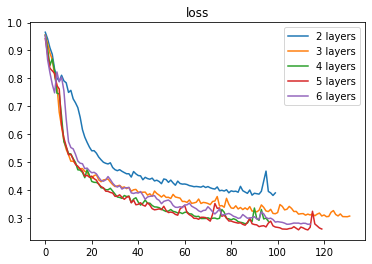

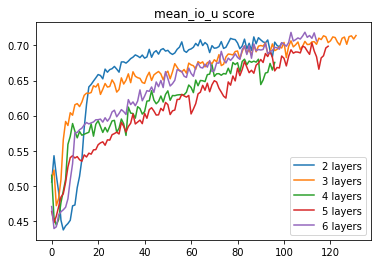

In [20]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(i+2))
plt.legend()
plt.title('loss')
plt.show()
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u_{}'.format(str(1+i))],label="{} layers".format(i+2))
plt.legend()
plt.title('mean_io_u score')
plt.show()

## prediction


(512, 512, 1)


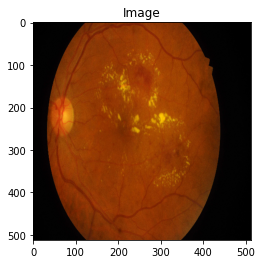

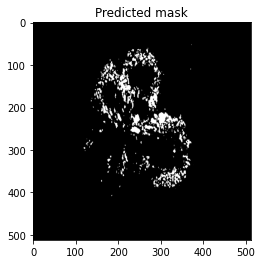

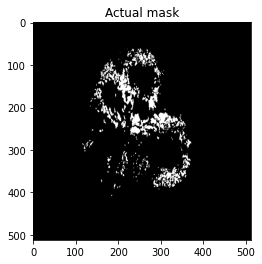

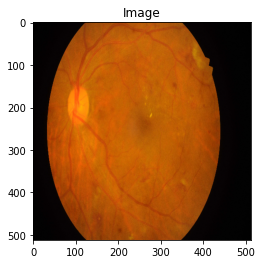

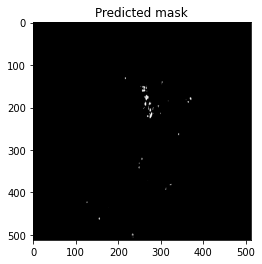

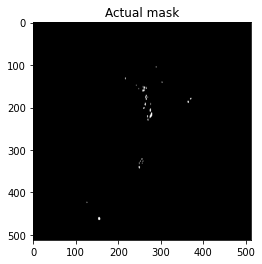

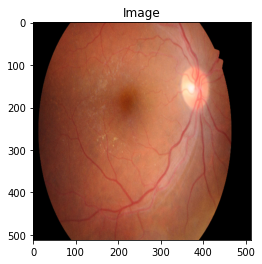

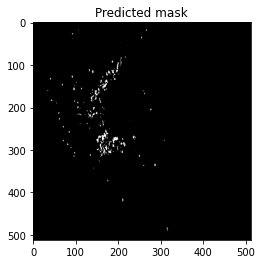

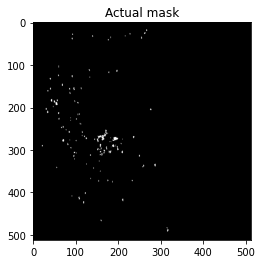

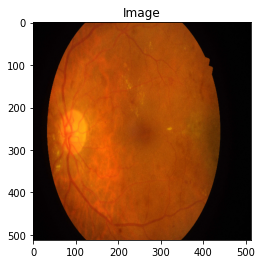

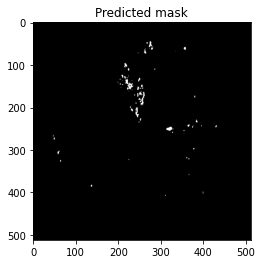

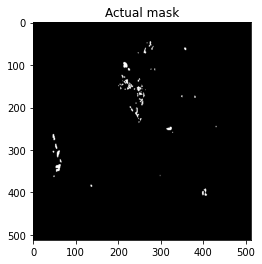

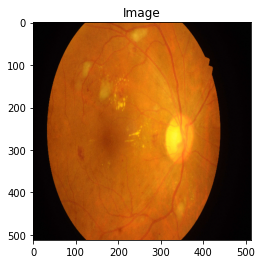

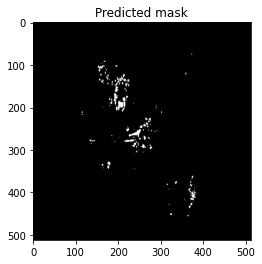

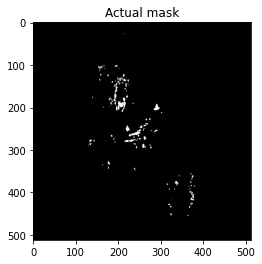

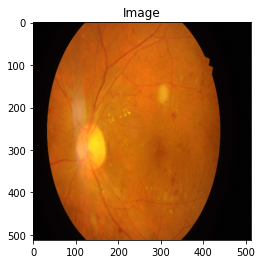

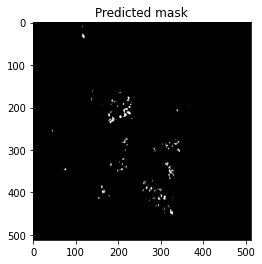

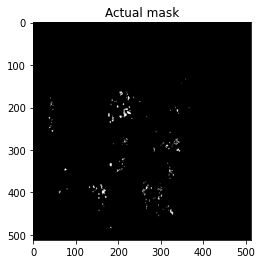

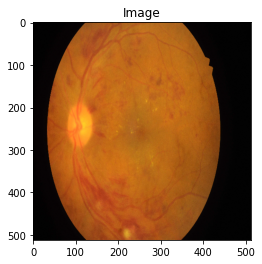

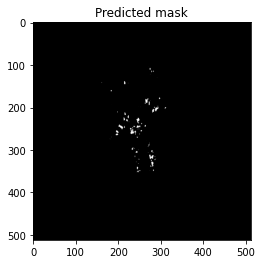

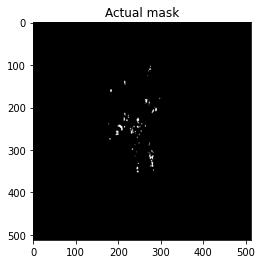

In [22]:
predicted_test_label=models[3].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(7):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

2 layers
train  0  test  0.8237868694063901
Train  F1 score: 0.000000 Test F1 score: 0.696277
train AUPR 0  test AUPR 0.6332521960704217


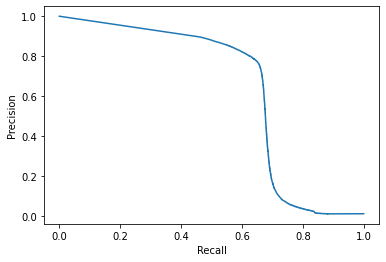

3 layers
train  0  test  0.8680330343958589
Train  F1 score: 0.000000 Test F1 score: 0.669187
train AUPR 0  test AUPR 0.6706410804091636


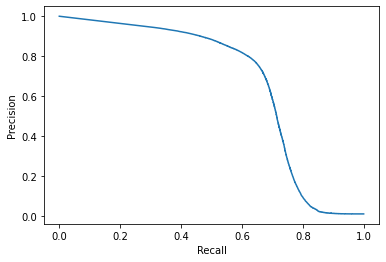

4 layers
train  0  test  0.9067317800361612
Train  F1 score: 0.000000 Test F1 score: 0.649959
train AUPR 0  test AUPR 0.6614855168577622


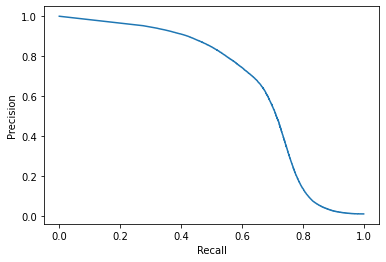

5 layers
train  0  test  0.9693740634926536
Train  F1 score: 0.000000 Test F1 score: 0.743472
train AUPR 0  test AUPR 0.7778260601472071


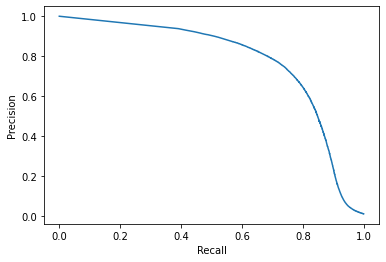

6 layers


ResourceExhaustedError: ignored

In [21]:
for i,model in enumerate(models):
  print(i+2, "layers")
  #generate the masks
 
  predicted_test_label=model.predict(test_batch)
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test ",test_auc)

  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  #AUPR

  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
  #train_auc=auc(train_aupr[1],train_aupr[0] )
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  del predicted_test_label 